<a href="https://colab.research.google.com/github/FabrizioCabreraC/Hollywood-as-recession-proof/blob/main/Hollywood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#%pip install cpi
%matplotlib inline
#%pip install scrapy
#import scrapy
#%pip install statsmodels
import statsmodels.api as sm
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Background

Every time the economy dips, trade papers and the general interest press starts starts to speculate about the effects on the entertainment and movie industry. [Commentators](https://www.hollywoodreporter.com/news/general-news/how-recession-proof-is-hollywood-now-1169172/) in the business section usually seem to be optimistic pointing to an increased need for distraction in times of hardship, whereas commentators from the culture sector seem to be pessimistic, especially concerning funding for highbrow enteertainment. To our knowledge, neither side has presented sound data to support its rerasoning; both rely completely on anecdotal evidence. Turning to the academic literature is not satisfactory either, since the rather few studies provide no clear answer but raise the question whether the state of the economy is an important influencing factor at all. Therefore, we believe that this is a relevant research topic. A better understanding of the influence of economic growth on the size and nature of the demand for cinema entertainment can ultimately lead to a betteer alloaction of production resources.

# Literature Review

The literature review of cinema supply and demand suggests that economic downturns could either lead to a sober mood and drive the interest in serious genres or drive the need for distraction leading to an increased interest in feel-good or action movies (Pettijohn and Sacco 2009). However, characteristics of the movie industry suggest that economic key factors have only limited effects on supply and demand (Langford 2004). Evidence of supply and demand in three major European markets indicate that demand is unrelated to the state of the economy. In aggregate accordding to (Peterson and Anand 2004: 317-8), the demand does not instruct supply. 

# Hypothesis

The project addresses whether the state of the economy impacts the supply of and demand for cinema entertainment: 

1.   To what extent can the state of the economy explain supply of and demand for cinema entertainment?

2.   Does the state of the economy influence the genre mix of the supply and the demand?

3.   ???Do other external influences besides the state of the economy have equal or maybe higher explanatory power concerning supply of and demand for cinema entertainment?

# Dataset

To try and answer the question of how recession proof the film in industry is we collected data from three different sources.

1.   Economic data was from the Federal Reserve Economic Database through the use of the FRED API. More specifically the fredapi package was used with a custom built funtion to pull individal series. This data includes, (but may not be linited to in the final draft) real GDP, CPI, Unemployment Rate, Consumer Confidence, real GDP per capita, and the Fed Funds Rate. The time series collected for these indicator varies, but was restructed to either show monthy (if available), or quarterly data. As of this moment all the variables were merged to start in 1990, as this is when gas price was first measured, but the data many be concatinated to allow a deeper range of years for the variables that have more data.

2.   Box office data was pulled from the monthly domestic box office tables on the website BoxOffice Mojo through read.html. This data was also modfied to show quarelty sums of total box office revneue and total films released. The quartely data was then merged into the data_qrt dataframe with the economic indicators.

3.   In order to obtain the average review ratings of movies released each year further film data was taken from links to the IMDB database. More specifcially the title.basics.tsv.gz and the title.ratings.tsv.gz tables from the IMDB data sets. These two data sets have been merged together to provide the yearly average review scores for all movies released. It has not yet been merged into the data.qrt table as it can only be measured buy the year, and we are now unsure if it will need to be used in the final project.


# Visualizations

Plots to be displayed will include charts showing the relationship between certain macroeconomic indicators and the supply and demand of the film industry since the 1980s. For instance, the charts will display a time series analysis that shows the state of the economy during those years. Thus, it will be observable how well the box office did during the recessions. 

Then, we would evaluate what happened in the cinema entertainment with respect to each variable: GDP, CPI, Unemployment Rate, Consumer Confidence, GDP per capita, the Fed Funds Rate. The charts will not only show the box office performance, but they will also display the market share movements related to the film industry during the pertinent period. In such a way, it will be seen whether Hollywood was affected by recessions and/or other non-economic factors, and by how much.

# Outline


1.   Examining economic variables
2.   Examining box office data
3.   Examining IMDB datasets
4.   Comments on graphs: answering our research questions
5.   Conclusion: discussion of limitations, areas for further research

Section 1: Pulls desired economic data series from FRED API

In [2]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of a series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data sereis complied on FRED website 
    
    returns:
    --------
    dataframe: a dataframe of the FRED metric according to the data series
    given to the function
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") # my API Key,
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"} #renames value columns given lable of 0 in some cases
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

Below use the get_fred fucntion to obatin the desiresed series that will be cleaned and put into a data set.

In [3]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp
GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP
consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent
debt_income = get_fred("TDSP") #total debt service to income ratio, by quater
#debt_income
gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita
gas_prices = get_fred("GASREGCOVW") #national gas price average, by week
#gas_prices
inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year
#inflation
PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more legible and useable.

In [4]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

Quick example plot.


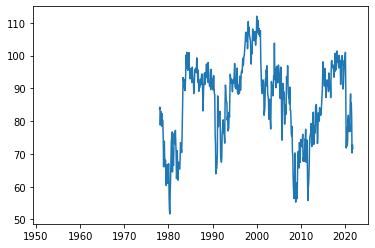

In [5]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [6]:
data_month = unemp.merge(consumer_sent.merge(gas_prices, on="Date", how="outer"))
#data_month.head(10)

data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head()

data_year = data_qrt.set_index("Date").resample("YS").mean()

Pulling in data from Box Office Mojo. This is the data from the film industry about the movie releases and gross revenues.

In [7]:
def get_table(url):
    '''
    Function gets the datatable requesuted from the boxoffice mojo
    url and outputs to a dataframe
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [8]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)

In [9]:

box_q1 = get_table("https://www.boxofficemojo.com/quarter/q1/?grossesOption=calendarGrosses")
box_q2 = get_table("https://www.boxofficemojo.com/quarter/q2/?grossesOption=calendarGrosses")
box_q3 = get_table("https://www.boxofficemojo.com/quarter/q3/?grossesOption=calendarGrosses")
box_q4 = get_table("https://www.boxofficemojo.com/quarter/q4/?grossesOption=calendarGrosses")

In [10]:
def reduce_table_year(df):
    jeff = df.drop(['%± LY', "Average", '#1 Release'], axis=1)
    jeff["Date"]= pd.to_datetime(jeff['Year'], format="%Y")
    return jeff

box_office_year = reduce_table_year(box_year)
box_office_year.head()

,Year,Total Gross,Releases,Date
0,2021,"$3,631,587,300",408,2021-01-01
1,2020,"$2,103,085,767",455,2020-01-01
2,2019,"$11,320,872,943",911,2019-01-01
3,2018,"$11,889,341,443",993,2018-01-01
4,2017,"$11,072,815,067",852,2017-01-01


In [11]:
def reduce_table(df, month: int):
    jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    'Genre', 'Budget', 'Running Time'], axis=1)
    jeff["month"] = month
    jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    return jeff

In [12]:
box_q1 = reduce_table(box_q1,1)
box_q2 = reduce_table(box_q2,4)
box_q3 = reduce_table(box_q3,7)
box_q4 = reduce_table(box_q4,10)

In [13]:
box_office_qrt = (pd.concat([box_q1,box_q2,box_q3,box_q4], axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office_qrt["gross"] = (box_office_qrt["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_year = box_office_year.sort_values(by=["Date"]).set_index("Date").drop(["Year"], axis=1).reset_index()

box_office_year["gross"] = (box_office_year["Total Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))
box_office_year = box_office_year.drop("Total Gross", axis=1)

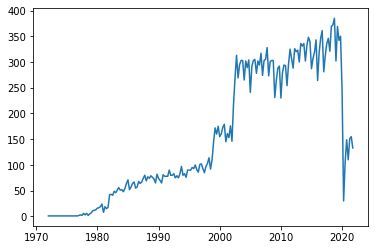

In [14]:
plt.plot(box_office_qrt.Releases)

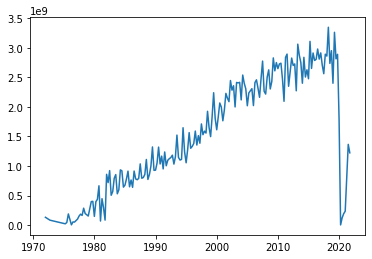

In [15]:
plt.plot(box_office_qrt.gross)

In [16]:
data_qrt_box = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_qrt_box["PCE"] = data_qrt_box["PCE"] * .01
data_qrt_box["gas_price"] = data_qrt_box["gas_price"]/data_qrt_box["PCE"]
data_qrt_box["gross"] = data_qrt_box["gross"]/data_qrt_box["PCE"]

#to scale gross to be measured in millions
data_qrt_box["gross"] = data_qrt_box["gross"] * .000001
# so the data starts in 1982 when the gross starts to make more sense
data_qrt_box = data_qrt_box.set_index("Date").loc["1980":"2020"]
data_qrt_box.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Cumulative Gross,Releases,Average,gross
Date,,,,,,,,,,,
1980-01-01,6.300000,63.466667,NaN,6842.024,30174.0,0.39716,10.615740,"$149,112,685",16.0,"$9,319,542",375.447389
1980-04-01,7.333333,54.366667,NaN,6701.046,29470.0,0.40689,10.636900,"$398,253,502",17.0,"$23,426,676",978.774367
1980-07-01,7.666667,67.766667,NaN,6693.082,29347.0,0.41641,10.406386,"$437,331,151",19.0,"$23,017,429",1050.241711
1980-10-01,7.400000,72.066667,NaN,6817.903,29813.0,0.42673,10.252837,"$666,317,624",24.0,"$27,763,234",1561.450153
1981-01-01,7.433333,68.266667,NaN,6951.495,30335.0,0.43781,10.287516,"$70,340,205",8.0,"$8,792,525",160.663770


In [17]:
box_office_year.head()

,Date,Releases,gross
0,1977-01-01,9,443497478
1,1978-01-01,13,840508376
2,1979-01-01,40,1244961893
3,1980-01-01,68,1657166297
4,1981-01-01,56,918310755


In [18]:
data_box_year = data_year.merge(box_office_year, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_box_year["PCE"] = data_box_year["PCE"] * .01
data_box_year["gas_price"] = data_box_year["gas_price"]/data_box_year["PCE"]
data_box_year["gross"] = data_box_year["gross"]/data_box_year["PCE"]
data_box_year["UNRATE"] = data_box_year["UNRATE"] * .01
#to scale gross to be measured in millions
data_box_year["gross"] = data_box_year["gross"] * .000001
# so the data starts in 1982 when the gross starts to make more sense
data_box_year = data_box_year.set_index("Date").loc["1982":"2020"]
data_box_year.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,0.097083,67.975000,NaN,6810.1200,29326.75,0.473567,10.435410,132.0,6352.537900
1983-01-01,0.096000,87.383333,NaN,7122.2905,30392.50,0.493670,10.383022,149.0,5567.348301
1984-01-01,0.075083,97.475000,NaN,7637.7040,32308.50,0.512373,10.671112,169.0,6058.671433
1985-01-01,0.071917,93.166667,NaN,7956.1695,33357.25,0.530250,11.463162,191.0,5735.936347
1986-01-01,0.070000,94.791667,NaN,8231.6635,34200.75,0.541813,11.882739,201.0,5726.692631


In [19]:
Original data cleaning.

In [20]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t')

In [22]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [23]:
df = df.query("titleType == 'movie' & isAdult == 0")
print(df.shape)
df.T.apply(lambda x: x.nunique(), axis=1)

(584190, 9)


tconst            584190
titleType              1
primaryTitle      506682
originalTitle     517381
isAdult                1
startYear            223
endYear                1
runtimeMinutes       486
genres              1376
dtype: int64

In [24]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1845
1,tt0000002,6.0,236
2,tt0000003,6.5,1603
3,tt0000004,6.0,153
4,tt0000005,6.2,2423


In [25]:
movies = df[["tconst","startYear","genres"]]
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["genres"] = movies["genres"].replace(r"\N", "null")
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before
movies = (
    movies.sort_values("startYear")
    .set_index("startYear")
    .dropna(how="any", axis=0)
)
movies = movies.loc["1980":"2020"].reset_index()
print(movies.shape)
print(movies.dtypes)

(327236, 3)
startYear    datetime64[ns]
tconst               object
genres               object
dtype: object


In [26]:
movies["genres"].value_counts()
split = movies["genres"].str.split(",", n = 3, expand = True)
print(split[0].unique()) #finally have a list of individual genres

# to remove all unwanted genres that don't seem to fit
bad_genres = [
    "Short",
    "null", 
    "Talk-Show", 
    "News", 
    "Game-Show", 
    "Reality-TV", 
    "Adult"]

for g in bad_genres:
    movies = movies[movies["genres"].str.contains(g) ==False]

movies.shape 
split

['Comedy' 'Adventure' 'Drama' 'Documentary' 'Action' 'null' 'Fantasy'
 'Horror' 'Crime' 'Animation' 'Sci-Fi' 'Family' 'Romance' 'Musical'
 'Thriller' 'Biography' 'Mystery' 'War' 'History' 'Sport' 'Western'
 'Music' 'Adult' 'Reality-TV' 'News' 'Talk-Show' 'Short' 'Game-Show']


,0,1,2
0,Comedy,None,None
1,Adventure,Comedy,None
2,Drama,None,None
3,Documentary,Music,None
4,Documentary,None,None
...,...,...,...
327231,Horror,None,None
327232,Documentary,None,None
327233,Documentary,None,None
327234,Fantasy,None,None


(182329, 6)

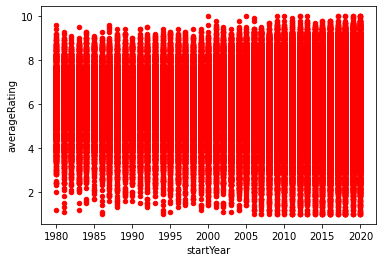

In [27]:
rated = pd.merge(movies, df_ratings, on="tconst", how="inner")
rated["weighted_ave"] = (rated["averageRating"] * rated["numVotes"]) 
rated.plot(x="startYear", y="averageRating", kind="scatter", color="r")
rated.head()
rated.shape

In [28]:
genres = pd.DataFrame()

genres["Date"] = rated.startYear
genres["tconst"] = rated.tconst

genre_list = [
    "Action",
    "Drama",
    "Adventure",
    "Comedy",
    "War",
    "Thriller",
    "Crime",
    "Animation",
    "Horror",
    "Biography",
    "History",
    "Western",
    "Documentary",
    "Romance",
    "Fantasy",
    "Family",
    "Musical",
    "Music",
    "Mystery",
    "Sci-Fi",
    "Sport"
]

for g in genre_list:
    genres[g] = rated["genres"].str.contains(g)


genres = genres.replace({True:1,False:0})
genres.head()


,Date,tconst,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,History,Western,Documentary,Romance,Fantasy,Family,Musical,Music,Mystery,Sci-Fi,Sport
0,1980-01-01,tt0081170,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1980-01-01,tt0080889,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1980-01-01,tt0081183,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1980-01-01,tt0079814,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1980-01-01,tt0318356,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Serious: A combination of the drama, documentary, history and biography, and thriller genres. The audience presumably watches this umbrella genre for reflection and intellectual stimulation (cognitive reception mode).

Middle: ...

Feel-good: A combination of the animation, comedies, romances, and musicals genres. The audience presumably watches this umbrella genre for distraction and for cheering up (affective/emotional reception mode).

In [29]:
genres["Act_adve"] = genres["Action"] + genres["Adventure"]
genres["Sci_fant"] = genres["Sci-Fi"] + genres["Fantasy"]
genres["Rom_com"] = genres["Romance"] + genres["Comedy"]
genres["Hor_thrill"] = genres["Horror"] + genres["Thriller"]
genres["Fam_ani"] = genres["Family"] + genres["Animation"]

genres["serious"]= (
    genres["Horror"] + 
    genres["Drama"] +
    genres["Thriller"] +
    genres["Crime"] +
    genres["War"]
)

genres["middle"] = (
    genres["Action"] + 
    genres["Adventure"] +
    genres["Sci-Fi"] +
    genres["Fantasy"] +
    genres["Western"] +
    genres["History"] +
    genres["Documentary"] + 
    genres["Biography"] +
    genres["Mystery"]
)

genres["Feel_good"]= (
    genres["Family"] + 
    genres["Comedy"] +
    genres["Romance"] +
    genres["Musical"] +
    genres["Music"] +
    genres["Animation"]
)

genres.shape

(182329, 31)

In [30]:
genres["Act_adve"] = genres["Act_adve"].replace({2:1})
genres["Rom_com"] = genres["Rom_com"].replace({2:1})
genres["Hor_thrill"] = genres["Hor_thrill"].replace({2:1})
genres["Fam_ani"] = genres["Fam_ani"].replace({2:1})
genres["Sci_fant"] = genres["Sci_fant"].replace({2:1})
genres["serious"] = genres["serious"].replace({2:1, 3:1})

genres["middle"] = genres["middle"].replace({2:1, 3:1})
genres["Feel_good"] = genres["Feel_good"].replace({2:1, 3:1})

genres = genres.set_index("Date").resample("YS").sum()
genres.head()


,Action,Drama,Adventure,Comedy,War,Thriller,Crime,Animation,Horror,Biography,History,Western,Documentary,Romance,Fantasy,Family,Musical,Music,Mystery,Sci-Fi,Sport,Act_adve,Sci_fant,Rom_com,Hor_thrill,Fam_ani,serious,middle,Feel_good
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980-01-01,328,991,126,519,53,135,185,27,127,42,49,10,103,166,55,81,56,100,59,54,15,402,109,630,224,102,1226,696,767
1981-01-01,271,972,140,514,55,123,175,38,145,43,54,6,128,207,52,103,59,99,67,47,10,367,97,667,228,131,1219,677,820
1982-01-01,289,1023,139,546,47,111,175,43,135,36,45,13,110,189,79,113,54,96,61,52,16,370,128,685,214,150,1264,674,864
1983-01-01,291,1080,156,552,73,132,185,39,106,37,51,9,131,227,86,89,56,102,66,53,20,390,136,716,220,117,1327,719,872
1984-01-01,298,1080,130,574,45,151,207,35,107,45,45,8,130,226,74,119,47,109,59,77,19,381,145,721,228,141,1325,719,888


,startYear,averageRating,numVotes,weighted_ave
0,1980-01-01,6.070961,3000.472707,22879.908406
1,1981-01-01,6.137579,2237.500526,16234.929053
2,1982-01-01,6.042843,2604.347137,18977.235736
3,1983-01-01,6.027424,2375.290402,17347.110578
4,1984-01-01,6.062123,3354.515062,24321.972000


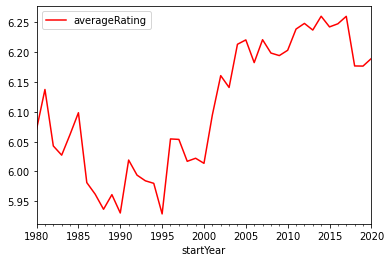

In [31]:
ave_rate = rated.groupby("startYear").mean()
ave_rate = pd.DataFrame(ave_rate).reset_index()
ave_rate.plot(x="startYear", y="averageRating", color="r")
ave_rate.head()

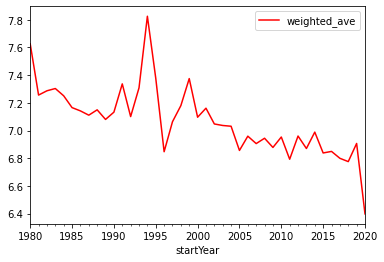

In [32]:
# weighted average rating

w_ave_rate = rated.groupby("startYear").sum()
w_ave_rate["weighted_ave"] = w_ave_rate["weighted_ave"] / w_ave_rate["numVotes"]
w_ave_rate.head()
w_ave_rate = w_ave_rate.reset_index()
w_ave_rate.plot(x="startYear", y="weighted_ave", color="r")


# Visualization

Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
				-We got the movie gross revenues (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		2-How does it shift the respective market shares of different genres?
		3-Do other external factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.
		4-Consumer confidence increased. *Key indicator to evaluate*


The objective of this project is threefold. First, we analyze whether there is a general impact of GDP per capita, consumer sentiment, and unemployment rate on the movie industry. By analyzing the number of movies released (supply) as well as the box office revenue (demand), we can distinguish between the reaction of the industry and that of the audience. In the second step, we capture possible shifts in the market shares of different genres by analyzing genre-specific supply and demand. Judging from the literature, we expect limited and delayed effects of changes in economic indicators on supply and demand for cinema entertainment. The time lag is likely to differ for the variables. Consumer confidence and demand may change synchronously while it would take some time for distributors to adjust supply to a changed GDP. In the third step, In the third step, we analyze whether there is actually a reciprocal relation between supply and demand and introduce historic event as alternative explanation.

### Influence of economic variables in the SUPPLY side of the film industry





In [38]:
# get the data_box_year in percent change so that we can plot them in the same graph

data_box_year_pct = data_box_year.pct_change()
data_box_year_pct.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,-0.011159,0.285522,NaN,0.045839,0.036341,0.042449,-0.005020,0.128788,-0.123603
1984-01-01,-0.217882,0.115487,NaN,0.072366,0.063042,0.037885,0.027746,0.134228,0.088251
1985-01-01,-0.042175,-0.044199,NaN,0.041696,0.032460,0.034892,0.074224,0.130178,-0.053268
1986-01-01,-0.026651,0.017442,NaN,0.034626,0.025287,0.021806,0.036602,0.052356,-0.001612


In [50]:
# I think we don't use this anymore.

# data_qrt_Datex = data_qrt.set_index('Date')
# data_qrt_Datex_pct = data_qrt_Datex.pct_change()
# data_qrt_Datex_pct.head()

Import new dataset that includes information about the US recession recessions. This is used to evaluate the movement of our explanatory variables during the recession periods.

In [40]:
%matplotlib inline

In [41]:
import matplotlib.pylab as plt
us_rec = get_fred("USREC") #recession indicator data
us_rec["Date"] = pd.to_datetime(us_rec["Date"])
us_rec["negative"] = us_rec["USREC"] * -1
us_rec = us_rec.set_index("Date").loc["1978":"2021"]
us_rec_scale = us_rec * 100000
us_rec.head()

,USREC,negative
Date,,
1978-01-01,0.0,-0.0
1978-02-01,0.0,-0.0
1978-03-01,0.0,-0.0
1978-04-01,0.0,-0.0
1978-05-01,0.0,-0.0


(-1.0, 1.0)

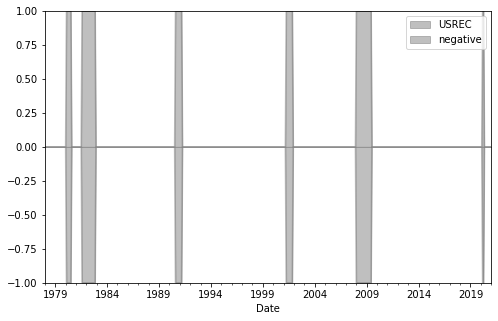

In [42]:
import io

# make sure date columns are actual dates

import matplotlib.pyplot as plt

# create plot (practice command)
fig, ax = plt.subplots()
us_rec.plot.area(ax=ax, figsize=(8, 5), alpha=0.5, color="gray")
plt.xlim("1978-01-01", "2021-01-01")
plt.ylim(-1.0, 1.0)

In [43]:
# genre Trial graph
genres_pct = genres.pct_change()


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


(-1.75, 1.75)

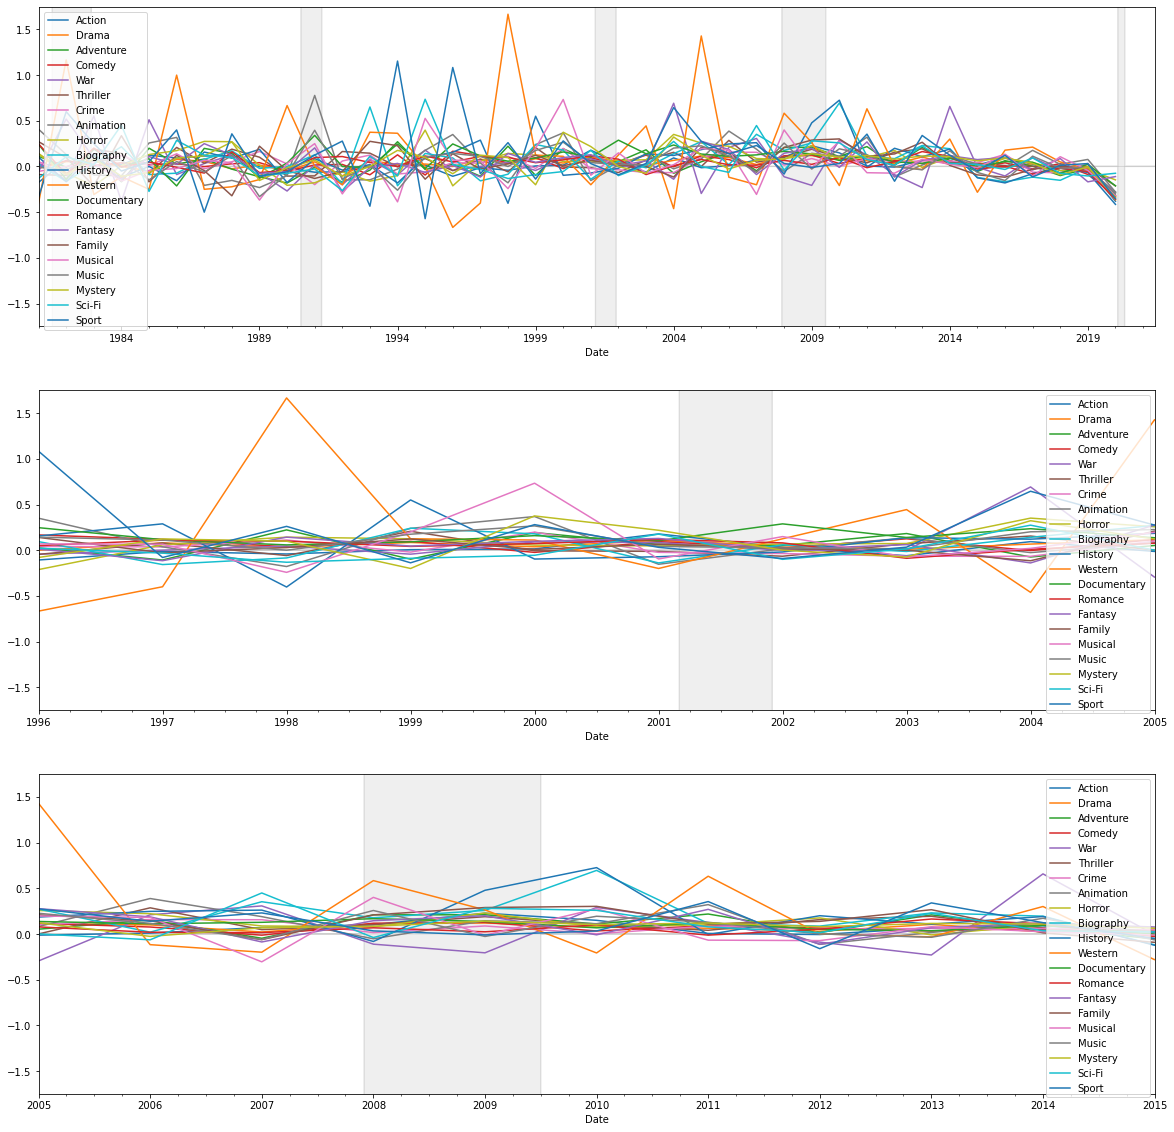

In [44]:

fig, axi = plt.subplots(3,1, figsize = (20,20))

us_rec_scale["USREC"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[0], alpha=0.12, color="gray", label=str())
genres_pct[genre_list].plot(ax=axi[0])
axi[0].legend(loc='best')
axi[0].set_xlim("1981-01-01", "2021-06-01")
axi[0].set_ylim(-1.75, 1.75)

us_rec_scale["USREC"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[1], alpha=0.12, color="gray", label=str())
genres_pct[genre_list].plot(ax=axi[1])
axi[1].legend(loc='best')
axi[1].set_xlim("1996-01-01", "2005-01-01")
axi[1].set_ylim(-1.75, 1.75)

us_rec_scale["USREC"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi[2], alpha=0.12, color="gray", label=str())
genres_pct[genre_list].plot(ax=axi[2])
axi[2].legend(loc='best')
axi[2].set_xlim("2005-01-01", "2015-01-01")
axi[2].set_ylim(-1.75, 1.75)



/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


(0.0, 4200.0)

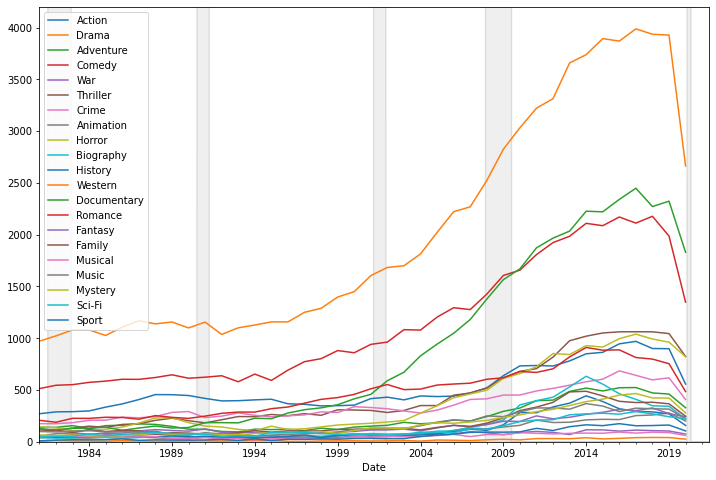

In [45]:

fig, axi = plt.subplots(figsize = (12,8))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
genres[genre_list].plot(ax=axi)
plt.legend(loc='best')
plt.xlim("1981-01-01", "2021-06-01")
plt.ylim(0, 4200)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


(0.0, 5700.0)

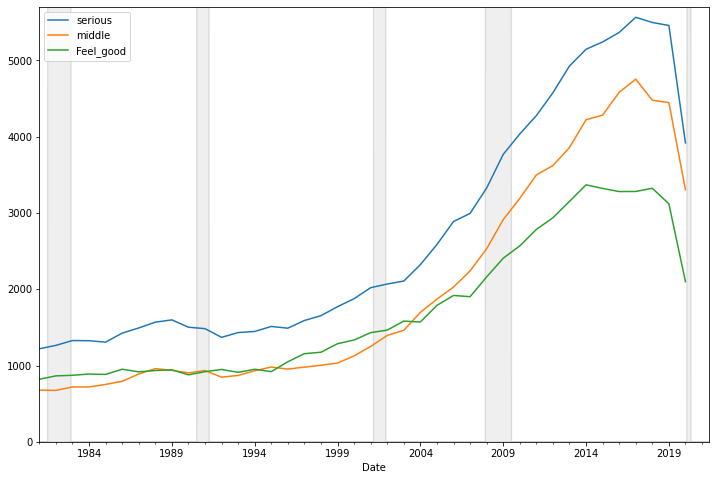

In [46]:
fig, axi = plt.subplots(figsize = (12,8))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
genres[["serious", "middle", "Feel_good"]].plot(ax=axi)
plt.legend(loc='best')
plt.xlim("1981-01-01", "2021-06-01")
plt.ylim(0, 5700)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


(-0.5, 0.5)

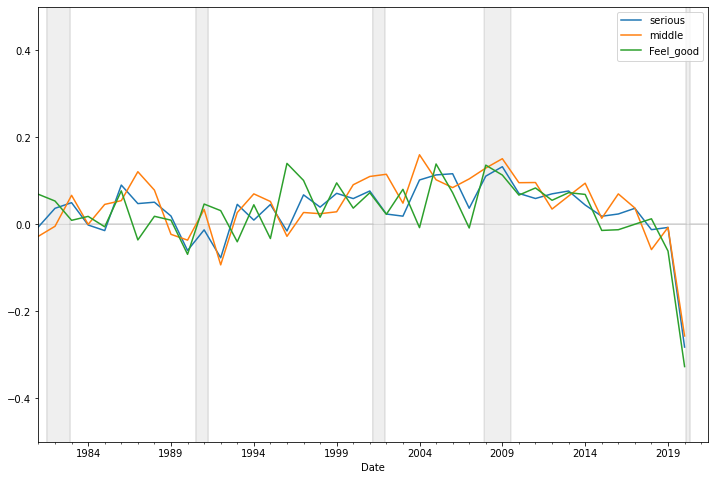

In [47]:
fig, axi = plt.subplots(figsize = (12,8))

us_rec_scale["USREC"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axi, alpha=0.12, color="gray", label=str())
genres_pct[["serious", "middle", "Feel_good"]].plot(ax=axi)
plt.legend(loc='best')
plt.xlim("1981-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

Text(2009-01-01, 500, 'The Great Recession')

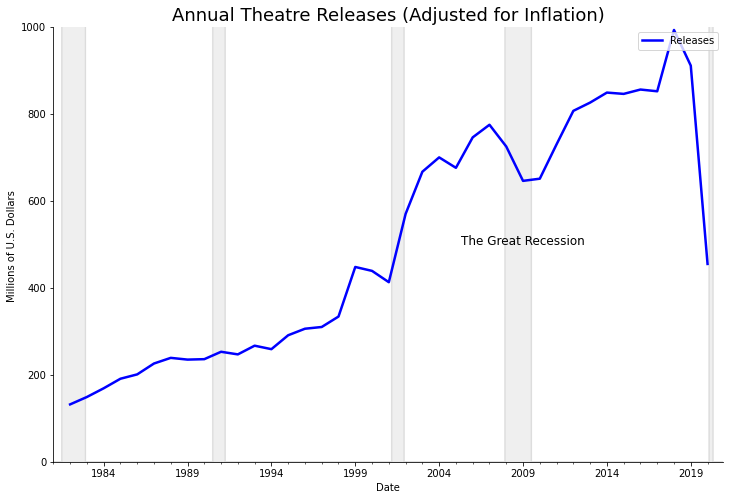

In [48]:
#trial graph 3
fig_0, ax_0 = plt.subplots(figsize=(12,8))

us_rec_scale["USREC"].plot.area(ax=ax_0, alpha=0.12, color="gray", label=str())

data_box_year['Releases'].plot(
    color = ('blue'), 
    ax=ax_0, 
    label="Releases",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper right')
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(0,1000)

ax_0.spines["right"].set_visible(False)
ax_0.spines["top"].set_visible(False)
ax_0.set_title(
    "Annual Theatre Releases (Adjusted for Inflation)",
    fontsize = 18)
ax_0.set_ylabel("Millions of U.S. Dollars ")

ax_0.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 500),
    fontsize=12,
     horizontalalignment="center")

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:1325: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


IndexError: ignored

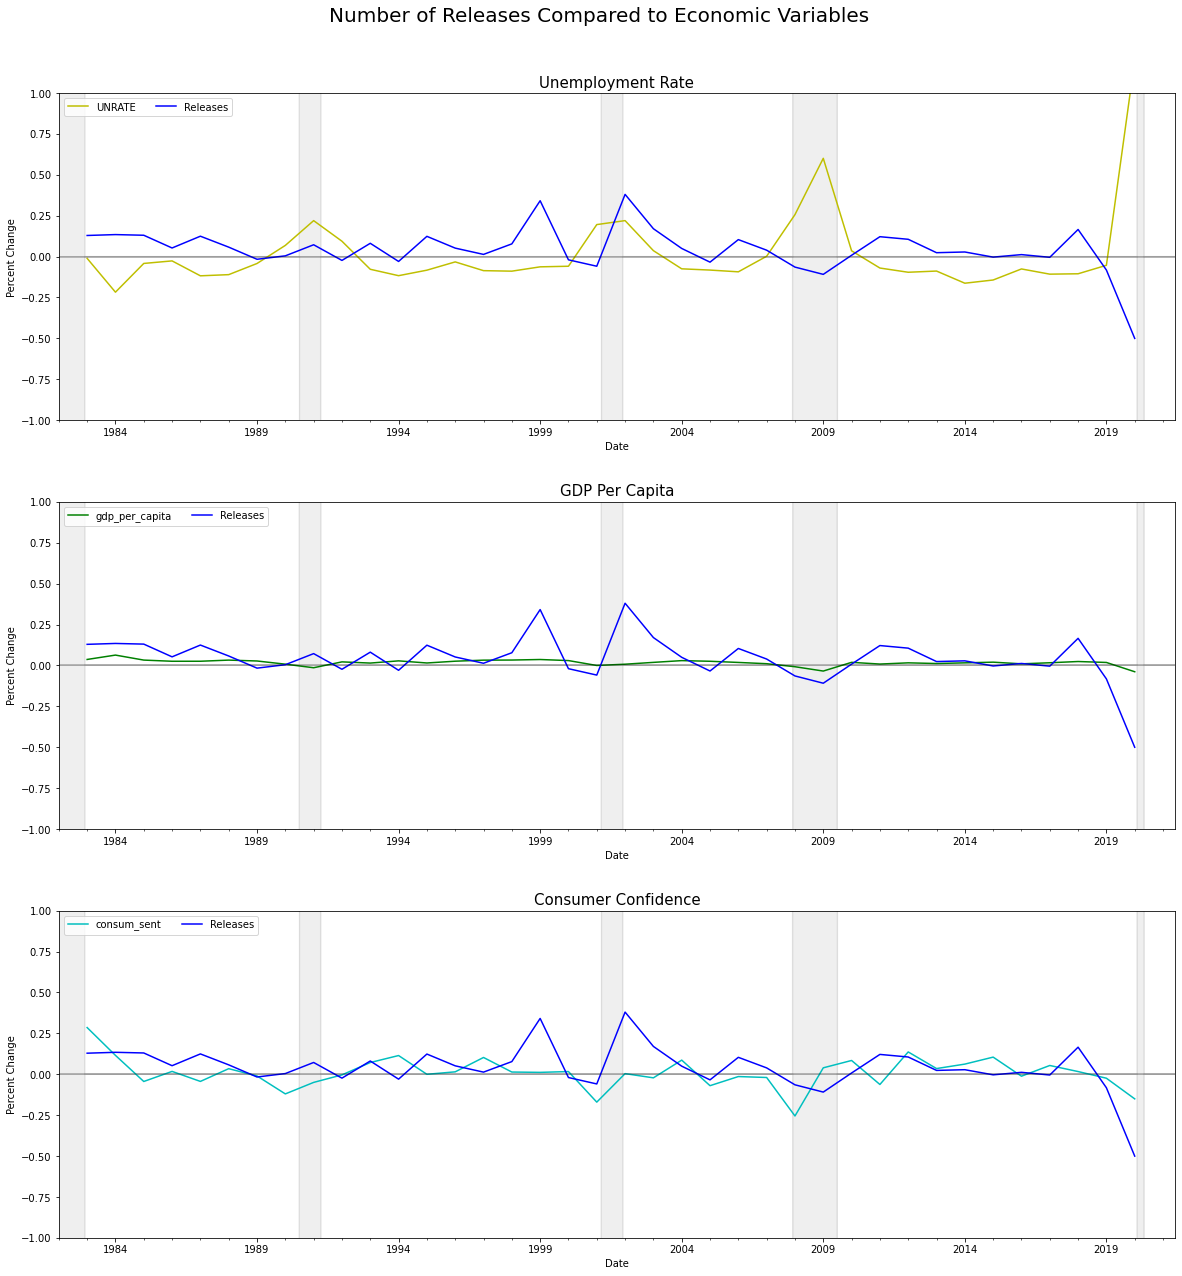

In [49]:
# attempt to clean this data 
fig, axs = plt.subplots(3, 1, figsize=(20,20))

fig.suptitle(
    "Number of Releases Compared to Economic Variables", 
    fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[0], alpha=0.12, color="gray", label=str())
data_box_year_pct[['UNRATE', 'Releases']].plot(ax=axs[0], color = ('y','b'))
axs[0].legend(loc='upper left', ncol=3, fancybox=True)
axs[0].set_xlim("1982-01-01", "2021-06-01")
axs[0].set_ylim(-1, 1)

us_rec_scale["USREC"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[1], alpha=0.12, color="gray", label=str())
data_box_year_pct[['gdp_per_capita', 'Releases']].plot(ax=axs[1], color = ('g','b'))
axs[1].legend(loc='upper left', ncol=3, fancybox=True)
axs[1].set_xlim("1982-01-01", "2021-06-01")
axs[1].set_ylim(-1, 1)

us_rec_scale["USREC"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=axs[2], alpha=0.12, color="gray", label=str())
data_box_year_pct[['consum_sent', 'Releases']].plot(ax=axs[2], color = ('c','b'))
axs[2].legend(loc='upper left', ncol=3, fancybox=True)
axs[2].set_xlim("1982-01-01", "2021-06-01")
axs[2].set_ylim(-1, 1)


axs[0].set_title("Unemployment Rate", fontsize=15)
axs[1].set_title("GDP Per Capita", fontsize=15)
axs[2].set_title("Consumer Confidence", fontsize=15)

axs[0].axhline(0, color="k", alpha=0.3)
axs[1].axhline(0, color="k", alpha=0.3)
axs[2].axhline(0, color="k", alpha=0.3)

axs[0].set_ylabel("Percent Change")
axs[1].set_ylabel("Percent Change")
axs[2].set_ylabel("Percent Change")

for i in axs:
    axs[i].axhline(0, color="k", alpha=0.3)
    axs[i].set_ylabel("Percent Change")

Plots showing the economic variables and releases

In [ ]:
# 0-Plot for the econoomic conditions with percentage change on the y-axis

# Data from previous cell cleaned

fig_5, ax_5 = plt.subplots(figsize=(10, 6))

fig_5.suptitle("\n".join([
                        "Percent Change of Releases Compared to Economic Variables"
                        ]), y=1.05, fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=ax_5, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_5, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['Releases'].plot(color = ('b'), ax=ax_5)
data_box_year_pct['UNRATE'].plot(color = ('y'), ax=ax_5)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.5, 0.8)
ax_5.set_title("Unemployment Rate", fontsize=15)
ax_5.axhline(0, color="k", alpha=0.3)
ax_5.set_ylabel("Percent Change")

fig_6, ax_6 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_6, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_6, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['Releases'].plot(color = ('b'), ax=ax_6)
data_box_year_pct['gdp_per_capita'].plot(color = ('g'), ax=ax_6)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.5, 0.6)
ax_6.set_title("GDP Per Capita", fontsize=15)
ax_6.axhline(0, color="k", alpha=0.3)
ax_6.set_ylabel("Percent Change")

fig_7, ax_7 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_7, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_7, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['Releases'].plot(color = ('b'), ax=ax_7)
data_box_year_pct['consum_sent'].plot(color = ('c'), ax=ax_7)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.5, 0.4)
ax_7.set_title("Consumer Confidence", fontsize=15)
ax_7.axhline(0, color="k", alpha=0.3)
ax_7.set_ylabel("Percent Change")

plt.show()

In [ ]:
fig_8, ax_8 = plt.subplots(figsize=(10, 6))

fig_8.suptitle("\n".join([
                        "Number of Releases Compared to Economic Variables"
                        ]), y=1.05, fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=ax_8, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_8, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['Releases'].plot(color = ('b'), ax=ax_8)
data_box_year['UNRATE'].plot(color = ('y'), ax=ax_8)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-100, 1000)
ax_8.set_title("Unemployment Rate", fontsize=15)
ax_8.axhline(0, color="k", alpha=0.3)
ax_8.set_ylabel("???")

fig_9, ax_9 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_9, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_9, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['Releases'].plot(color = ('b'), ax=ax_9)
data_box_year['gdp_per_capita'].plot(color = ('g'), ax=ax_9)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-100, 60000)
ax_9.set_title("GDP Per Capita", fontsize=15)
ax_9.axhline(0, color="k", alpha=0.3)
ax_9.set_ylabel("???")

fig_10, ax_10 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_10, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_10, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['Releases'].plot(color = ('b'), ax=ax_10)
data_box_year['consum_sent'].plot(color = ('c'), ax=ax_10)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(0, 1000)
ax_10.set_title("Consumer Confidence", fontsize=15)
ax_10.axhline(0, color="k", alpha=0.3)
ax_10.set_ylabel("???")

plt.show()

In [ ]:
# 3-Plot for the econoomic conditions on the y-axis

data_box_year[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['consum_sent', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.show()

### Influence of economic variables in the DEMAND side of the film industry


In [ ]:
#trial graph 1
fig, ax = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['gross'].plot(color = ('r'), ax=ax)
data_box_year_pct['UNRATE'].plot(color = ('y'), ax=ax)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.8, 0.8)

In [ ]:
#trial graph 2
fig_1, ax_1 = plt.subplots(figsize=(12,8))

us_rec_scale["USREC"].plot.area(ax=ax_1, alpha=0.12, color="gray", label=str())

data_box_year['gross'].plot(
    color = ('red'), 
    ax=ax_1, 
    label="Gross",
    linewidth = 2.5)

plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper right')
plt.xlim("1981-01-01", "2020-12-31")
plt.ylim(0,15000)

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.set_title(
    "Annual Box Office Gross (Adjusted for Inflation)",
    fontsize = 18)
ax_1.set_ylabel("Millions of U.S. Dollars ")

ax_1.annotate(
    "The Great Recession",
    xy = ("2009-01-01", 7500),
    fontsize=12,
     horizontalalignment="center")

The variable for cumulative revenue is "gross".
I still need to add the recession bars.

In [ ]:
# 1-Plot for the econoomic conditions with percentage change on the y-axis

fig, ax = plt.subplots(figsize=(10, 6))

fig.suptitle("\n".join([
                        "Percent Change of Gross Revenues Compared to Economic Variables"
                        ]), y=1.05, fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=ax, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['gross'].plot(color = ('r'), ax=ax)
data_box_year_pct['UNRATE'].plot(color = ('y'), ax=ax)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.8, 0.8)
ax.set_title("Unemployment Rate", fontsize=15)
ax.axhline(0, color="k", alpha=0.3)
ax.set_ylabel("Percent Change")

fig_2, ax_2 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_2, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_2, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['gross'].plot(color = ('r'), ax=ax_2)
data_box_year_pct['gdp_per_capita'].plot(color = ('g'), ax=ax_2)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.8, 0.2)
ax_2.set_title("GDP Per Capita", fontsize=15)
ax_2.axhline(0, color="k", alpha=0.3)
ax_2.set_ylabel("Percent Change")

fig_3, ax_3 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_3, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_3, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year_pct['gross'].plot(color = ('r'), ax=ax_3)
data_box_year_pct['consum_sent'].plot(color = ('c'), ax=ax_3)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-0.8, 0.35)
ax_3.set_title("Consumer Confidence", fontsize=15)
ax_3.axhline(0, color="k", alpha=0.3)
ax_3.set_ylabel("Percent Change")

plt.show()

The values of gross revenues are too large to plot them together with another variable.
The values of gross revenues make the other variables look flat.

In [ ]:
# 2-Plot for the economic conditions on the y-axis

fig_11, ax_11 = plt.subplots(figsize=(10, 6))

fig_11.suptitle("\n".join([
                        "Gross Revenues Compared to Economic Variables"
                        ]), y=1.05, fontsize = 20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=.92, wspace=None, hspace=.25)

us_rec_scale["USREC"].plot.area(ax=ax_11, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_11, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['gross'].plot(color = ('b'), ax=ax_11)
data_box_year['UNRATE'].plot(color = ('y'), ax=ax_11)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-100, 15000)
ax_11.set_title("Unemployment Rate", fontsize=15)
ax_11.axhline(0, color="k", alpha=0.3)
ax_11.set_ylabel("???")

fig_12, ax_12 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_12, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_12, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['gross'].plot(color = ('b'), ax=ax_12)
data_box_year['gdp_per_capita'].plot(color = ('g'), ax=ax_12)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(-100, 60000)
ax_12.set_title("GDP Per Capita", fontsize=15)
ax_12.axhline(0, color="k", alpha=0.3)
ax_12.set_ylabel("???")

fig_13, ax_13 = plt.subplots(figsize=(10, 6))
us_rec_scale["USREC"].plot.area(ax=ax_13, x='Date', alpha=0.2, color="gray", label=str())
us_rec_scale["negative"].plot.area(ax=ax_13, x='Date', alpha=0.2, color="gray", label=str())
plt.xlim("1982-01-01", "2021-01-01")
data_box_year['gross'].plot(color = ('b'), ax=ax_13)
data_box_year['consum_sent'].plot(color = ('c'), ax=ax_13)
plt.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)
plt.xlim("1982-01-01", "2021-06-01")
plt.ylim(0, 15000)
ax_13.set_title("Consumer Confidence", fontsize=15)
ax_13.axhline(0, color="k", alpha=0.3)
ax_13.set_ylabel("???")

plt.show()

# The economic variables arer plotted alone from here on

data_box_year[['UNRATE']].plot(color = ('y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['gdp_per_capita']].plot(color = ('g'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")

data_box_year[['consum_sent']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")


plt.show()